# IST 718: Big Data Analytics

- Professor: Daniel Acuna <deacuna@syr.edu>

## General instructions:

- You are welcome to discuss the problems with your classmates but __you are not allowed to copy any part of your answers either from your classmates or from the internet__
- You can put the homework files anywhere you want in your https://jupyterhub.ischool.syr.edu/ workspace but _do not change_ the file names. The TAs and the professor use these names to grade your homework.
- Remove or comment out code that contains `raise NotImplementedError`. This is mainly to make the `assert` statement fail if nothing is submitted.
- The tests shown in some cells (i.e., `assert` and `np.testing.` statements) are used to grade your answers. **However, the professor and TAs will use __additional__ test for your answer. Think about cases where your code should run even if it passess all the tests you see.**
- Before downloading and submitting your work through Blackboard, remember to save and press `Validate` (or go to 
`Kernel`$\rightarrow$`Restart and Run All`). 
- Good luck!

In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torch.utils.data import TensorDataset, DataLoader
import torch
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt
import numpy as np

## Question 1 (35 pts):

In this homework, we will analyze different architectures for the prediction of MNIST digits.
The code below will load the MNIST data and create a data loader for training and testing (`trainloader` and `testloader`, respectively). Also, the code defines a special layer that flattens a volumetric layer into a set of neurons (`Flatten`) leaving the road ready for creating a fully connected layer.

In [2]:
# READ ONLY CELL
# MNIST dataset
transform = transforms.Compose(
    [transforms.ToTensor()])
train_dataset = torchvision.datasets.MNIST(root='~', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root='~', train=False, transform=transform)

# create training and testing data
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=4,
                                         shuffle=False, num_workers=0)

# special module to flatten a layer
# Flattens the dimensions of a convolutional network. This module does not exist in pytorch so we have
# to create it
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /home/jovyan/MNIST/raw/train-images-idx3-ubyte.gz to /home/jovyan/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /home/jovyan/MNIST/raw/train-labels-idx1-ubyte.gz to /home/jovyan/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /home/jovyan/MNIST/raw/t10k-images-idx3-ubyte.gz to /home/jovyan/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /home/jovyan/MNIST/raw/t10k-labels-idx1-ubyte.gz to /home/jovyan/MNIST/raw

Processing...


/opt/conda/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [2]:
# Get MNIST dataset
!wget www.di.ens.fr/~lelarge/MNIST.tar.gz

!tar -zxvf MNIST.tar.gz
from torchvision.datasets import MNIST
transform = transforms.Compose([transforms.ToTensor()])
train_dataset = MNIST(root = './', train=True, download=True, transform=transform)
val_dataset = MNIST(root = './', train=False, download=True, transform=transform)
# create training and testing data
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=4,
                                          shuffle=True, num_workers=0)
testloader = torch.utils.data.DataLoader(val_dataset, batch_size=4,
                                         shuffle=False, num_workers=0)
# special module to flatten a layer
# Flattens the dimensions of a convolutional network. This module does not exist in pytorch so we have
# to create it
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

--2021-12-17 15:12:33--  http://www.di.ens.fr/~lelarge/MNIST.tar.gz
Resolving www.di.ens.fr (www.di.ens.fr)... 129.199.99.14
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://www.di.ens.fr/~lelarge/MNIST.tar.gz [following]
--2021-12-17 15:12:33--  https://www.di.ens.fr/~lelarge/MNIST.tar.gz
Connecting to www.di.ens.fr (www.di.ens.fr)|129.199.99.14|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/x-gzip]
Saving to: ‘MNIST.tar.gz.1’

MNIST.tar.gz.1          [            <=>     ]  33.20M  14.0MB/s    in 2.4s    

2021-12-17 15:12:36 (14.0 MB/s) - ‘MNIST.tar.gz.1’ saved [34813078]

MNIST/
MNIST/raw/
MNIST/raw/train-labels-idx1-ubyte
MNIST/raw/t10k-labels-idx1-ubyte.gz
MNIST/raw/t10k-labels-idx1-ubyte
MNIST/raw/t10k-images-idx3-ubyte.gz
MNIST/raw/train-images-idx3-ubyte
MNIST/raw/train-labels-idx1-ubyte.gz
MNIST/raw/t10k-images-idx3-ubyte
MNIST/raw

The following function creates a neural network but requires you to specificy the correct input and output dimensions to the last layer, which is a fully connected layer.

In [3]:
# READ ONLY CELL
def create_cnn(fully_connected_input, fully_connected_output):
    """
    Convolutional neural network with
    CONV => ReLU => MaxPool => FC
    """
    model = nn.Sequential(
        nn.Conv2d(1, 3, kernel_size=4, stride=2, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=3, stride=3),    
        Flatten(),
        nn.Linear(fully_connected_input, fully_connected_output)
    )
    return model

The function create_cnn creates a very specific architecture (CONV => ReLU => MaxPool => FC) but requires you to enter the correct number of input neurons for the fully connected layer (fully_connected_input) and output neurons for the network (fully_connected_output).
Consider that the MNIST images have width and height 28. The convolutional layer has a 3 kernels of size 4, stride of 2, and padding of 2. The max pooling layer has a kernel size of 3 and stride of 3. \
Below, define the appropriate variables `fully_connected_input` and `fully_connected_output` so that create_cnn can be appropriately used to create a CNN for the MNIST dataset. Consider that for MNIST you are predicting digits.
Use the equations seen in class to compute the volume of the convolution layer and max pooling layer. You will use this volumes and slice dimensions for determining these variables.

In [6]:
# define fully_connected_input and fully_connected_output
# YOUR CODE HERE

fully_connected_input = 75
fully_connected_output = 10

create_cnn(fully_connected_input, fully_connected_output)

Sequential(
  (0): Conv2d(1, 3, kernel_size=(4, 4), stride=(2, 2), padding=(2, 2))
  (1): ReLU()
  (2): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (3): Flatten()
  (4): Linear(in_features=75, out_features=10, bias=True)
)

Prediction from uninitialized CNN: tensor([[-0.1123, -0.2173, -0.2402, -0.1976, -0.2158,  0.0016,  0.0579, -0.3989,
          0.0350,  0.0256]], grad_fn=<AddmmBackward>)


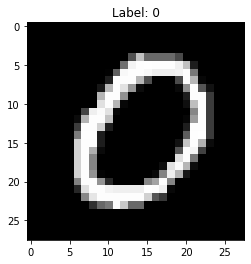

In [7]:
# 35 pts
X, label = next(iter(trainloader))
plt.imshow(X[0, 0].numpy(), 'gray');
plt.title(f'Label: {str(label[0].numpy())}');
assert create_cnn(fully_connected_input, fully_connected_output)
model = create_cnn(fully_connected_input, fully_connected_output)
print(f"Prediction from uninitialized CNN: {model(X[[0]])}")